In [26]:
import sys
sys.path.append('../classes')
sys.path.append('../datastorage')

import os
import time
import redpitaya_scpi as scpi
import numpy as np
from redpitaya_class import redpitaya_scope as redpitaya_scope
import datastorage_class as ds
import matplotlib.pyplot as plt
import addcopyfighandler
import mplcursors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from IPython.core.debugger import set_trace

def prepare_datastorage():
    #--------------------------------------------------------------------------
    # Create the datastorage
    #--------------------------------------------------------------------------
    Data = ds.datastorage_class('datastorage')

    return Data


def prepare_measurement(Scope, Data):
    Scope.SetDecimationBeta(10)    
    Scope.SetInputGain(Channel = 1, Gain = 'LV')
    Scope.SetInputGain(Channel = 2, Gain = 'LV')
    Scope.SetProbeGain(Probe = 1, Gain = 1)
    Scope.SetProbeGain(Probe = 2, Gain = 1)
    Scope.SetAverage(0)
    Scope.SetTrigger(Trigger = "NOW")
        
    Data.add_title("Red Pitaya Scope")
    Data.add_name("Time")
    Data.add_name("Channel 1")
    Data.add_name("Channel 2")

    Data.add_name("TriggerTime")
    Data.add_name("TriggerData")
    
    return Data


def plot_measurement(Scope, Data):
    
    fig, axes = plt.subplots(1, 1)

    plt.rcParams['figure.figsize'] = [12, 6]

    plt.minorticks_on()
    plt.tight_layout()
    
    label_ch1 = ("Channel 1 (Probe %0.fx)" % + Scope.GetProbeGain(1))
    label_ch2 = ("Channel 2 (Probe %0.fx)" % + Scope.GetProbeGain(2))
    label_trig = ("Trigger position")

    Data.plot_data(axes, "Time", "Channel 1", color=21, points_only=False, label=label_ch1,  title='', marker='', linewidth=1)
    Data.plot_data(axes, "Time", "Channel 2", color=22, points_only=False, label=label_ch2,  title='', marker='', linewidth=1)
    Data.plot_data(axes, "TriggerTime", "TriggerData", color=23, points_only=False, label=label_trig,  title='', marker='', linewidth=1)
    
    SetPlotXAxis(Scope, Data, axes)
    SetPlotYAxis(Scope, Data, axes)
        
    axes.grid(visible=True)
    axes.set(ylabel='Distance [mm]', xlabel='Time [mSec]')
    axes.set_title(Data.title)
    
    return fig, axes

def SetPlotYAxis(Scope, Data, axis):
    YRange = Scope.GetYRange()    

    axis.grid(which='minor', alpha=0.3)
    axis.grid(which='major', alpha=1.0)

    Major = YRange / 10;
    Minor = YRange / 20;    

    y_major_ticks = np.arange(-1 * YRange, YRange + Minor, Major)
    y_minor_ticks = np.arange(-1 * YRange, YRange + Minor, Minor)

    axis.set_yticks(y_major_ticks)
    axis.set_yticks(y_minor_ticks, minor=True)
    
    axis.set_ylim([-1 * Scope.GetYRange(), Scope.GetYRange()])

    return

def SetPlotXAxis(Scope, Data, axis):
   
    axis.set_xlim([0, Scope.GetDuration() * 1000])

    return

In [31]:
def save_measurements(Scope, Data):
    Data.save_data("Testing1.dat")
    return

In [32]:
def do_measurement(Scope, Data):
    Scope.SetTrigger(Trigger = "DISABLED")
    Scope.Start()   
    
    # Sleep is only needed when trigger delay = 0 (middle of the data) 
    # In that case we want to make sure the pre-trigger buffer is full
    # before setting the actual trigger.
    time.sleep(1)
    
    #Scope.SetTrigger(Trigger = "CH1_PE", Level = 0.25, Delay = 0)
    Scope.SetTrigger(Trigger = "NOW")
    Scope.PrintSettings()
    
    Scope.WaitForTrigger()
    
    # Timing with the scpi interface is not very good.
    # Quite some timing overhead seems to be present.
    
    # WaitForTrigger() returns immediately after the trigger event
    # and does not wait for the buffer to fill to the end.
    # Add sleep(some number) if data seems not oke.
    # sleep time can be calculated based on the sample frequency and the
    # number of samples after the trigger event.
    
    time.sleep(1)   
   
    Data.add_data("Time", Scope.GetTimeVector() * 1000)
    Data.add_data("Channel 1",  Scope.GetGain(1) * Scope.GetData_Txt(Channel = 1))
    Data.add_data("Channel 2",  Scope.GetGain(1) * Scope.GetData_Txt(Channel = 2))

    Data.add_data("TriggerTime", Scope.GetTriggerVector() * 1000)
    Data.add_data("TriggerData", Scope.GetTriggerData())

    # Pitaya.tx_txt('ACQ:STOP');
    
    print("Trigger delay   : %.6f Sec"  % ((8192-0)/Scope.Frequency))
    
    return Data

Decimation      : 1024
Frequency       : 122.070 kHz
Duration        : 134.218 msec
Trigger         : NOW
Trigger Delay   : 8192 samples
Trigger Level   : 0.000 Volt (on ADC level)
Range 1         : +/-1.0 Volt
Range 2         : +/-1.0 Volt
Probe 1         : 1x
Probe 2         : 1x
TD
Trigger delay   : 0.067109 Sec


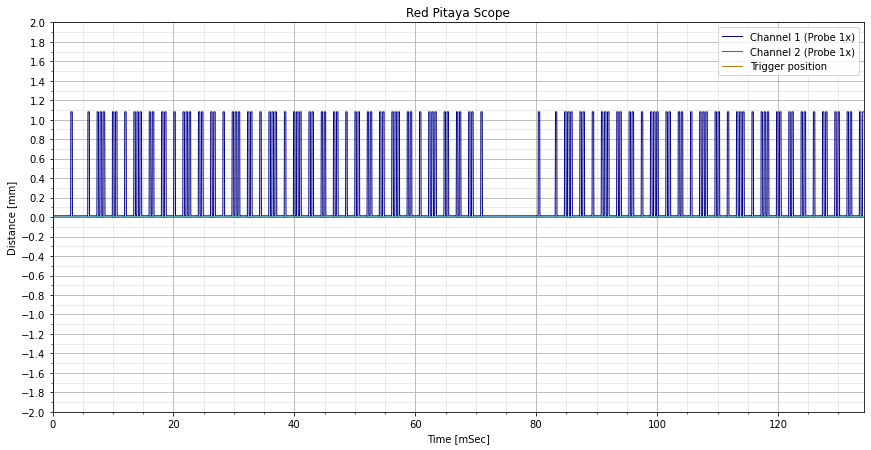

In [36]:
#==============================================================================
# Main
#==============================================================================
ip = "192.168.3.150"

# datastorage class to handle data & plotting    
Data            = prepare_datastorage()

# option to load old data
# data.load_data('Simulation_200mm_250mm_0.6sec_22.data')

# create a scpi object.
Pitaya      = scpi.scpi(ip)
   
# Create a scope object and set some parameters
Scope       = redpitaya_scope(Pitaya);     

Data        = prepare_measurement(Scope, Data)
Data        = do_measurement(Scope, Data)
fig, axes   = plot_measurement(Scope, Data)

save_measurements(Scope, Data)

mplcursors.cursor(axes, multiple=True)

# load_meausurements(Scope, Data)

Pitaya.close()


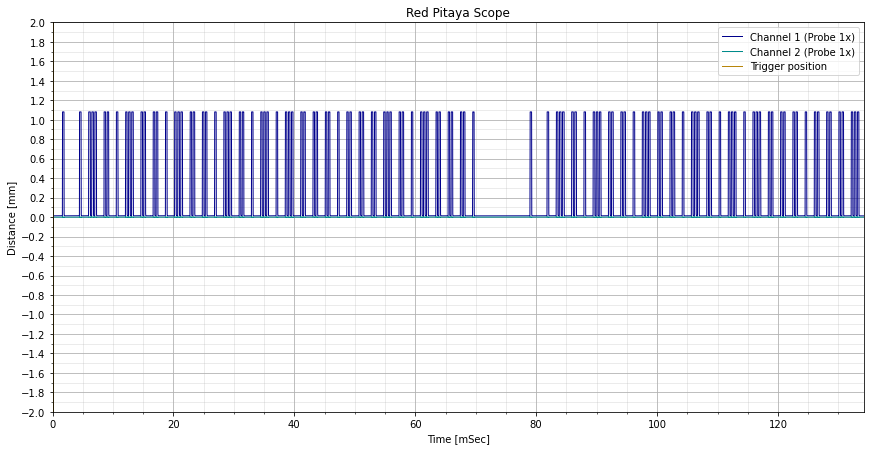

In [35]:
Data2       = prepare_datastorage()
Data2.load_data("Testing1.dat")

fig, axes = plot_measurement(Scope, Data2)

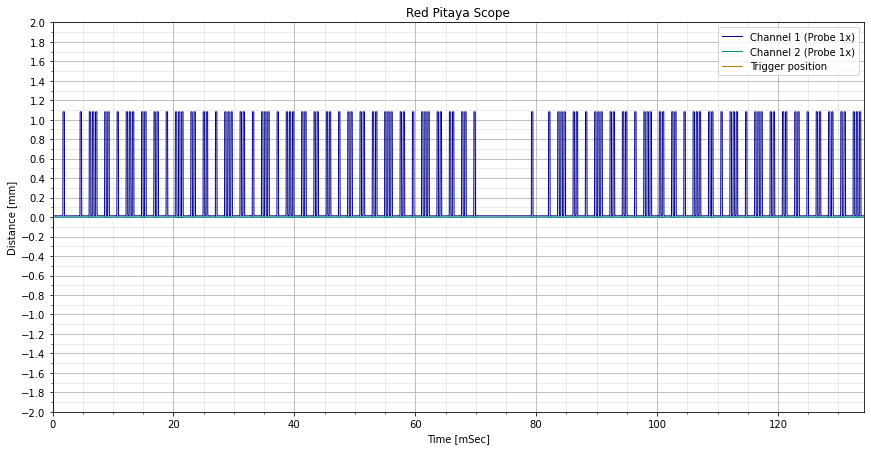

In [30]:
Data2       = prepare_datastorage()
Data2.load_data("Testing2.dat")

fig, axes = plot_measurement(Scope, Data2)